In [13]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ternary
from datetime import date
import geopandas as gpd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import ListedColormap
import functools as ft
import matplotlib.patches
from matplotlib.colors import ListedColormap, BoundaryNorm
from scipy.ndimage import gaussian_filter


In [2]:
scaled_data = pd.read_csv("/home/lavinia/dottorato/github/data_for_ternary.csv")

In [3]:
# data extraction for the temporal windows
night_data = scaled_data.query("reason==0 and time_of_day=='night'")[['cluster', 'grid_id', 'low', 'medium', 'high']].rename(columns={'low': 'low_night', 'medium': 'medium_night', 'high': 'high_night'})
morning_data = scaled_data.query("reason==1 and time_of_day=='morning'")[['cluster','grid_id', 'low', 'medium', 'high']].rename(columns={'low': 'low_morning', 'medium': 'medium_morning', 'high': 'high_morning'})
afternoon_data = scaled_data.query("reason==2 and time_of_day=='afternoon'")[['cluster','grid_id', 'low', 'medium', 'high']].rename(columns={'low': 'low_afternoon', 'medium': 'medium_afternoon', 'high': 'high_afternoon'})


merged_data = pd.merge(pd.merge(night_data, morning_data), afternoon_data)


In [4]:
# Constants
SQRT3 = np.sqrt(3)
SQRT3OVER2 = SQRT3 / 2.

# Functions for point permutation and projection
def permute_point(p, permutation=None):
    """Permutes the point based on the given permutation."""
    if not permutation:
        return p
    return [p[int(permutation[i])] for i in range(len(p))]

def project_point(p, permutation=None):
    """Maps (x,y,z) coordinates to planar simplex."""
    permuted = permute_point(p, permutation=permutation)
    a = permuted[0]
    b = permuted[1]
    x = a + b/2.
    y = SQRT3OVER2 * b
    return np.array([x, y])





In [5]:
def compute_kde_and_interp(data, nbins=11):
    H, b = np.histogramdd((data[:, 0], data[:,1], data[:,2]),
                          bins=(nbins, nbins, nbins), range=((0, 1), (0, 1), (0, 1)))
    H = H / np.sum(H)
    kde = gaussian_filter(H, sigma=2)
    interp_dict = dict()
    binx = np.linspace(0, 1, nbins)
    for i, x in enumerate(binx):
        for j, y in enumerate(binx):
            for k, z in enumerate(binx):
                interp_dict[(i, j, k)] = kde[i, j, k]
    return interp_dict

def plot_ternary_heatmap(ax, data, cmap, vmin=0, vmax=0.009):
    tax = ternary.TernaryAxesSubplot(ax=ax, scale=10)
    tax.heatmap(data, vmin=vmin, vmax=vmax, colorbar=False, cmap=plt.cm.get_cmap(cmap))
    tax.boundary(linewidth='0.5')
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    
def draw_arrows(ax, proj_start, proj_end, multiplier):
    """
    Function to draw arrows on a given axis using starting and ending projections.
    
    Parameters:
    - ax: Axis on which to draw
    - proj_start: Starting projections
    - proj_end: Ending projections
    - multiplier: Multiplier for axis adjustments (e.g., 10 for 'x' and 8 for 'y')
    """
    x0 = np.array(proj_start)[:,0]
    y0 = np.array(proj_start)[:,1]
    x1 = np.array(proj_end)[:,0]
    y1 = np.array(proj_end)[:,1]

    dX = x1-x0
    dY = y1-y0

    data = pd.concat([pd.DataFrame(np.array(proj_start), columns=['x','y']),
                      pd.DataFrame(dX, columns=['d_x']),
                      pd.DataFrame(dY, columns=['d_y'])], axis=1).round(1)

    grouped_data = data.groupby(['x', 'y']).agg({'d_x': ['mean','count'], 'd_y': 'mean'}).reset_index()

    for i in range(len(grouped_data)):
        x_pos = grouped_data['x'].values[i] * multiplier[0]
        y_pos = grouped_data['y'].values[i] * multiplier[1]
        x_direct = grouped_data['d_x']['mean'][i]
        y_direct = grouped_data['d_y']['mean'][i] # dx per averle tutte nello stesso senso
        lun = np.log(grouped_data['d_x']['count'][i]) / 400

        L = np.sqrt(x_pos**2 + y_pos**2)
        U = x_direct / L 
        V = y_direct / L 

        U1 = lun * U
        V1 = lun * V

        ax.quiver(x_pos, y_pos, U1, V1, width=lun, color='black', angles='xy')


    


/tmp/ipykernel_17452/497329861.py:53: RuntimeWarning: divide by zero encountered in double_scalars
  U = x_direct / L
/tmp/ipykernel_17452/497329861.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  V = y_direct / L
/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/matplotlib/quiver.py:689: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/matplotlib/quiver.py:671: RuntimeWarning: Mean of empty slice.
  amean = a[~self.Umask].mean()
/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


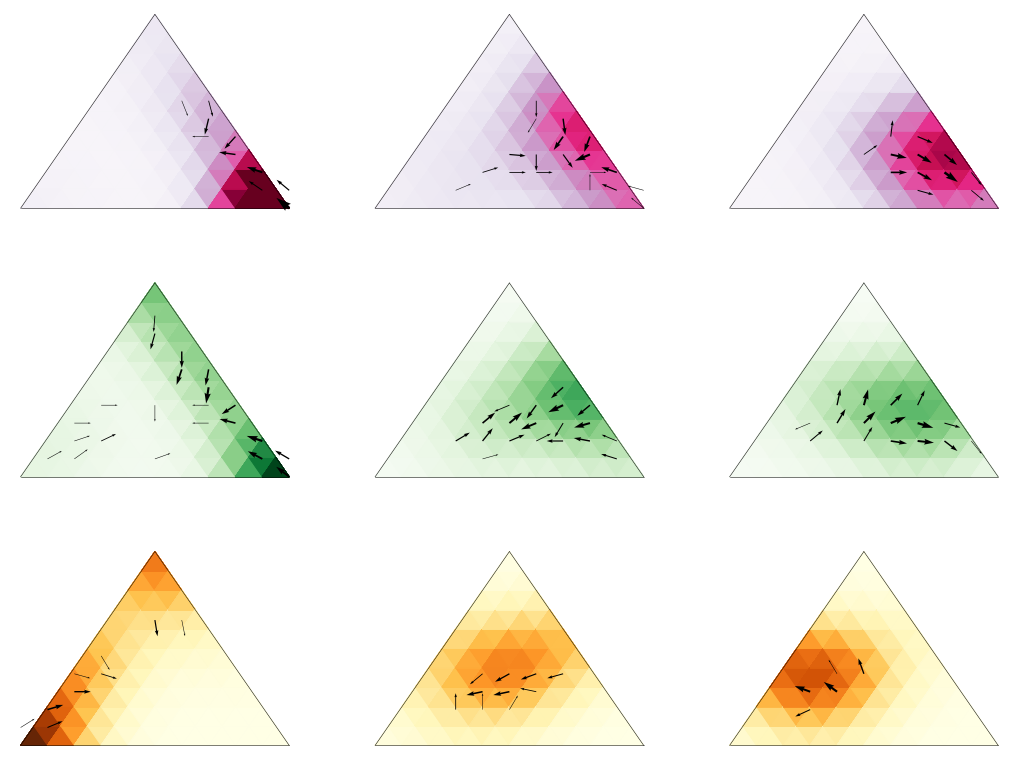

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(18,14))
cmap_colors = ['PuRd', 'Greens', 'YlOrBr']

for c in range(3):
    cluster_data = merged_data.query("cluster==@c")
    plot_data = [
        cluster_data[['low_night', 'medium_night', 'high_night']].to_numpy(),
        cluster_data[['low_morning', 'medium_morning', 'high_morning']].to_numpy(),
        cluster_data[['low_afternoon', 'medium_afternoon', 'high_afternoon']].to_numpy()
    ]
    proj_points = [] # List to store projections
    for idx, data in enumerate(plot_data):
        interp_data = compute_kde_and_interp(data)
        plot_ternary_heatmap(ax[c, idx], interp_data, cmap_colors[c])

        # Calculate the projections for each time_of_day and append to proj_points
        projections = [project_point(p) for p in data]
        proj_points.append(projections)

    # Retrieve the projected points
    proj_i, proj_f, proj_l = proj_points

    # For night to morning
    draw_arrows(ax[c, 0], proj_i, proj_f, [10, 8])

    # For morning to afternoon
    draw_arrows(ax[c, 1], proj_f, proj_l, [10, 8])

    # For afternoon back to night
    draw_arrows(ax[c, 2], proj_l, proj_i, [10, 8])



In [7]:
# Define helper functions
def gini(x):
    """Compute Gini coefficient of an array."""
    total = 0
    for i, xi in enumerate(x[:-1], 1):
        total += np.sum(np.abs(xi - x[i:]))
    return total / (len(x)**2 * np.mean(x))

def compute_segregation(data, columns):
    """Compute segregation based on provided columns."""
    data['p'] = data[columns].values.tolist()
    return [gini(np.array(row)) for row in data['p']]

def process_data(data, col_prefix):
    """Process data by computing segregation and other necessary transformations."""
    col_names = [f"{suffix}_{col_prefix}" for suffix in ['low', 'medium', 'high']]
    data[['high', 'low', 'medium']] = data[col_names].round(1)
    
    # Compute segregation
    data[f'segregation_{col_prefix}'] = compute_segregation(data, ['high', 'low', 'medium'])
    
    # Add 'h' and 'x' assignments
    data['h'] = f'segregation_{col_prefix}'
    data['x'] = data[f'segregation_{col_prefix}']
    return data

# Process the data
night_data = process_data(night_data, 'night')
morning_data = process_data(morning_data, 'morning')
afternoon_data = process_data(afternoon_data, 'afternoon')

# Combining segregation data
segregation_dataframes = [
    night_data[['h', 'x', 'cluster']],
    afternoon_data[['h', 'x', 'cluster']],
    morning_data[['h', 'x', 'cluster']]
]
combined_segregation_data = pd.concat(segregation_dataframes)



/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/seaborn/axisgrid.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self._figure.tight_layout(*args, **kwargs)
/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/lavinia/anaconda3/envs/prova/lib/python3.9/site-packages/seaborn/axisgrid.py:703: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_args = [v for k, v in plot_data.iteritems()]
/home/lavinia/anaconda3/envs/prova/

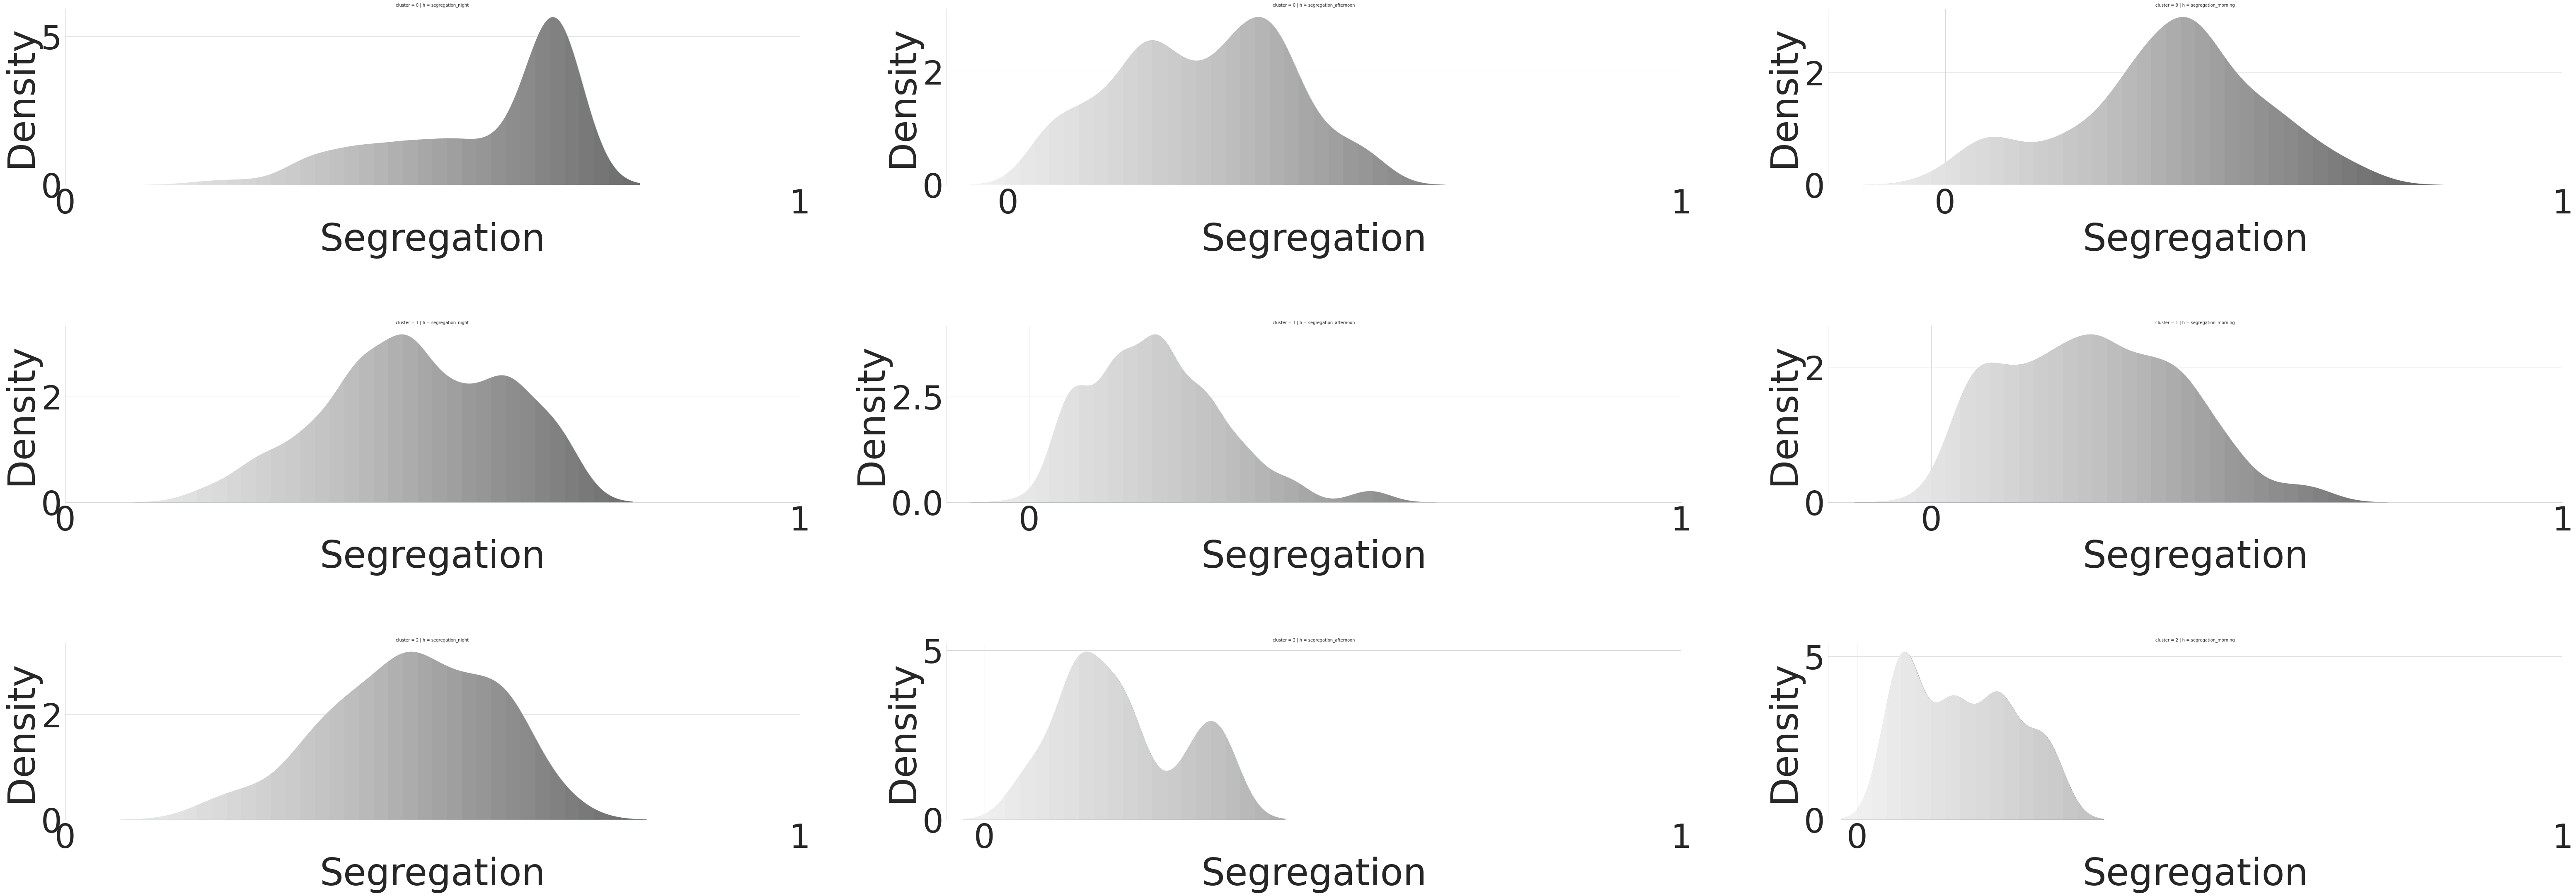

In [8]:
import matplotlib.pyplot as plt
import matplotlib.patches
import seaborn as sns

# Set up aesthetics
sns.set_style("whitegrid")
pal = sns.cubehelix_palette(4, rot=-0.25, light=0.7)

# Create the FacetGrid
g = sns.FacetGrid(combined_segregation_data, row='cluster', col='h', hue='h',
                  aspect=3, height=12, gridspec_kws={"hspace": 0.8}, palette=pal, sharex=False, sharey=False)

# Draw the densities
g = g.map(sns.kdeplot, 'x', fill=True, alpha=0.8, lw=1, bw_adjust=0.8)
g = g.map(sns.kdeplot, 'x', color='w', lw=0.6, bw_adjust=0.8)
g = g.map(plt.axhline, y=0, lw=1)

# Adjust title and axis labels directly
for ax in g.axes.flat:
    ax.set_xlabel('Segregation', fontsize=90)
    ax.set_ylabel('Density', fontsize=90)
    ax.set(xticks=range(0, 2))
    ax.tick_params(axis='both', which='major', labelsize=80)
    ax.tick_params(axis='both', which='minor', labelsize=78)

# Generate a gradient
min_val, max_val = 0.1, 0.8
n = 100
orig_cmap = plt.cm.Greys
colors = orig_cmap(np.linspace(min_val, max_val, n))
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom_greys", colors)

for ax in g.axes.flat:
    im = ax.imshow(np.vstack([np.linspace(0, 1, 50), np.linspace(0, 1, 50)]),
                   aspect='auto', cmap=cmap, zorder=10, extent=[*ax.get_xlim(), *ax.get_ylim()])
    path = ax.collections[0].get_paths()[0]
    patch = matplotlib.patches.PathPatch(path, transform=ax.transData)
    im.set_clip_path(patch)

plt.tight_layout()
plt.show()


In [9]:
feature_data=gpd.read_file("/home/lavinia/dottorato/github/ala_metrics.json")

/tmp/ipykernel_17452/3180885831.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbr = fig.colorbar(sm, cax=cax,)


<AxesSubplot:>

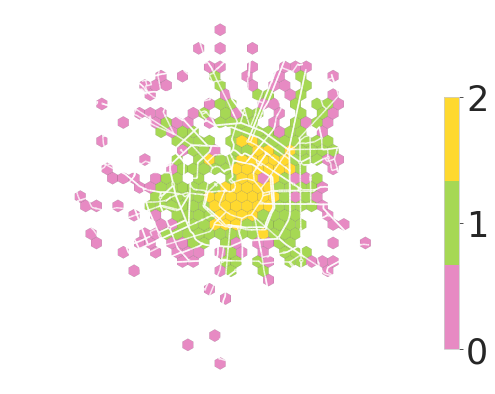

In [10]:

palette = sns.color_palette("Set2", 12).as_hex()[3:6]
my_cmap = ListedColormap([palette[0],palette[1],palette[2]])


street=gpd.read_file("/home/lavinia/dottorato/github/street.geojson")
street.to_crs("EPSG:3395")
fig, ax = plt.subplots(figsize = (7,7))

feature_data.to_crs("EPSG:3395").plot(column='cluster',legend=False,cmap=my_cmap,ax=ax,vmin=0,vmax=3,edgecolor='black', linewidth=0.08)
plt.axis('off')
cax = fig.add_axes([1, 0.2, 0.03, 0.5])
sm = plt.cm.ScalarMappable(cmap=my_cmap, norm=plt.Normalize(vmin=0, vmax=2))
sm._A = []
cbr = fig.colorbar(sm, cax=cax,)
cbr.ax.tick_params(labelsize=35) 
street.to_crs("EPSG:3395").plot(ax=ax,zorder=1,alpha=0.8,color='white')

In [11]:
afternoon_data=gpd.GeoDataFrame(pd.merge(afternoon_data,feature_data[['grid_id','geometry']]))

/tmp/ipykernel_17452/3352827705.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbr = fig.colorbar(sm, cax=cax, ticks=[afternoon_data['x'].min(), afternoon_data['x'].max()])


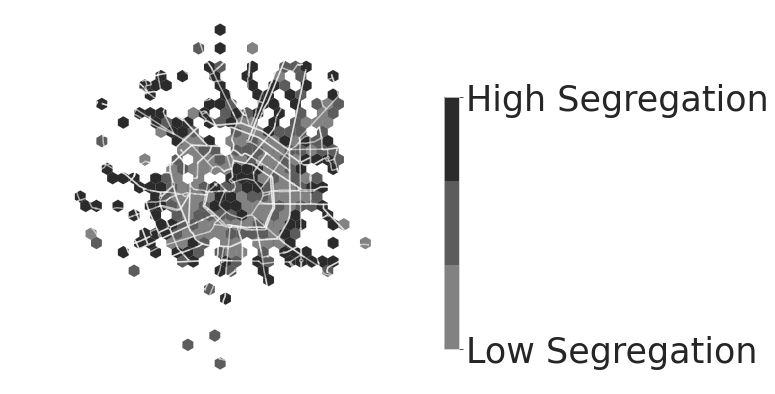

In [12]:
# Define the darker shades of grey
grey_dark = ListedColormap([
    (0.5085736255286428, 0.5085736255286428, 0.5085736255286428),
    (0.35912341407151094, 0.35912341407151094, 0.35912341407151094),
    (0.1679354094579008, 0.1679354094579008, 0.1679354094579008)
])

# Define normalization bounds for three intervals
bounds = [afternoon_data['x'].min(), 
          afternoon_data['x'].quantile(0.33), 
          afternoon_data['x'].quantile(0.67), 
          afternoon_data['x'].max()]
norm_dark = BoundaryNorm(bounds, grey_dark.N)

# Load the data
street = gpd.read_file("/home/lavinia/dottorato/github/street.geojson")
street = street.to_crs("EPSG:3395")

# Plotting
fig, ax = plt.subplots(figsize=(7,7))
afternoon_data.to_crs("EPSG:3395").plot(column='x', legend=False, cmap=grey_dark, norm=norm_dark, ax=ax, edgecolor='black', linewidth=0.08)
street.plot(ax=ax, zorder=1, alpha=0.6, color='white')

# Remove the axes
plt.axis('off')

# Add a colorbar
cax = fig.add_axes([1, 0.2, 0.03, 0.5])
sm = plt.cm.ScalarMappable(cmap=grey_dark, norm=norm_dark)
sm._A = []  # This line is needed for the colorbar
cbr = fig.colorbar(sm, cax=cax, ticks=[afternoon_data['x'].min(), afternoon_data['x'].max()])
cbr.ax.set_yticklabels(['Low Segregation', 'High Segregation'])  # set the labels
cbr.ax.tick_params(labelsize=35) 

# Display the plot
plt.show()

